<a href="https://colab.research.google.com/github/cosminnedescu/ProjectMLDL/blob/main/baselines/FineTuning-group.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import os

import torch
import torch.nn as nn
import torch.nn.init as init
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import transforms, datasets, models
from torch.utils.data import Subset, DataLoader

from PIL import Image

import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

In [ ]:
%cd ../

/


In [ ]:
%cd content/

/content


In [3]:
!rm -rf ProjectMLDL

In [ ]:
!ls

sample_data


In [4]:
if not os.path.isdir('/content/ProjectMLDL'):
  !git clone https://github.com/cosminnedescu/ProjectMLDL.git
  %cd /content/ProjectMLDL
  !rm -rf LICENSE README.md

Cloning into 'ProjectMLDL'...
remote: Enumerating objects: 78, done.
remote: Counting objects: 100% (78/78), done.
remote: Compressing objects: 100% (69/69), done.
remote: Total 78 (delta 23), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (78/78), done.
/content/ProjectMLDL


In [11]:
from data.cifar100 import CIFAR100
from model.resnet32 import resnet32
import data.utils
from model.trainer import Trainer
from copy import copy

In [6]:
# True mean and std of Cifar100 dataset (src="https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151")
mean = [0.5071, 0.4867, 0.4408]
std = [0.2675, 0.2565, 0.2761]

train_transform = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])
test_transform = transforms.Compose(
    [transforms.ToTensor(), 
     transforms.Normalize(mean, std),
     ])

In [7]:
train_data = CIFAR100("dataset", train=True, transform=train_transform, download=True)
test_data = CIFAR100("dataset", train=False, transform=test_transform, download=True)

Extracting dataset/cifar-100-python.tar.gz to dataset
Files already downloaded and verified


classe: 90


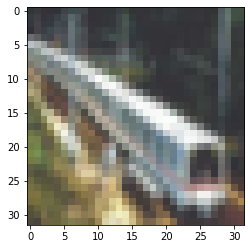

In [ ]:
#check images and labels after shuffle
#https://github.com/keras-team/keras/issues/2653#issuecomment-450133996
import matplotlib.pyplot as plt

plt.imshow(train_data.data[6])
print("classe: {}".format(train_data.targets[6]))

In [8]:
RANDOM_SEED = [42,13,10]
# Settings
DEVICE = 'cuda'

NUM_CLASSES = 100       # Total number of classes

VAL_SIZE = 0.1          # Proportion of validation set with respect to training set (between 0 and 1)

# Training
BATCH_SIZE = 128        # Batch size
LR = 2               # Initial learning rate
                       
MOMENTUM = 0.9          # Momentum for stochastic gradient descent (SGD)
WEIGHT_DECAY = 1e-5     # Weight decay from iCaRL

NUM_RUNS = 3            # Number of runs of every method
                        # Note: this should be at least 3 to have a fair benchmark

NUM_EPOCHS = 70         # Total number of training epochs
MILESTONES = [49, 63]   # Step down policy from iCaRL (MultiStepLR)
                        # Decrease the learning rate by gamma at each milestone
GAMMA = 0.2             # Gamma factor from iCaRL

In [ ]:
criterion = nn.CrossEntropyLoss()

## Training Larocca

In [ ]:
class FineTuning(nn.Module):
  def __init__(self, n_classes):
    super(FineTuning, self).__init__()
    self.feature_extractor = resnet32()
    self.n_classes = n_classes
    self.n_known = 0
    self.p = self.parameters()
    self.fc = nn.Linear(10, n_classes, bias = True)

  def forward(self, x):
    x = self.feature_extractor(x)
    x = self.fc(x)
    return x

  def increment_classes(self, n):
    in_features = self.feature_extractor.in_features
    out_features = self.fc.out_features
    weight = self.fc.weight.data
    bias = self.fc.bias.data

    self.fc = nn.Linear(in_features, out_features+n, bias=True)
    self.fc.weight.data[:out_features] = weight
    self.fc.bias.data[:out_features] = bias
    self.n_classes += n


In [ ]:
train_dataloader = [[] for i in range(len(RANDOM_SEED))]
test_dataloader = [[] for i in range(len(RANDOM_SEED))]

best_acc = []
tot_matrix = []
tot_labe = []

#net = FineTuning(10)
net = resnet32()


for run_i in range(len(RANDOM_SEED)):
  random_state = RANDOM_SEED[run_i]
  subset_train = []
  subset_test = []

  train_data.__shuffle_seed__(RANDOM_SEED[run_i])
  test_data.__shuffle_seed__(RANDOM_SEED[run_i])

  indexes_train_data = train_data.__incremental_indexes__(True)
  indexes_test_data = test_data.__incremental_indexes__(False)

  train_dataloader = []
  test_dataloader = []

  for i in range(10):
    train_dataset = Subset(train_data, indexes_train_data[i])
    subset_train.append(train_dataset) #[[train0],[train1],...]
    train_dataloader=DataLoader(subset_train[i],
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=4,
                                              drop_last=True)
    
    test_dataset = Subset(test_data, indexes_test_data[i])
    subset_test.append(test_dataset) #[[train0],[train1],...]
    test_dataloader=DataLoader(subset_test[i],
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=4,
                                              drop_last=True)
    net.cuda()
    if(i!=0):
      net.addOutputNodes(10)
      
    net.train()
    
    p = net.parameters()
    optimizer = optim.SGD(p, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA)

    matrix = []
    labe = []    
    b_ac = 0
    #Training

    for epoch in range(0, NUM_EPOCHS):
      running_corrects = 0
      total = 0

      for indices, images, labels in train_dataloader:
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        indices = indices.cuda()
        optimizer.zero_grad()
        g = net(images)
        #print(g)
        #g = net.forward(images)
        _, preds = torch.max(g, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()
        total += labels.size(0)


        #Loss
        g.cuda()
        #print("Loss1 : {}".format(loss))
        loss = criterion(g, labels)
        #print("Loss2 : {}".format(loss))
        loss.backward()
        #print("Loss3 : {}".format(loss))
        optimizer.step()

      accuracy = running_corrects / float(total)
      scheduler.step()
      print ('Epoch (%d/%d), Loss: %.4f, Accuracy: %.2f' %(epoch+1, NUM_EPOCHS, loss, accuracy))

      #test
      m = []
      l = []
      #net.train(False)
      net.eval()  #per spegnere i layer di dropout
      total = 0.0
      running_corrects = 0
      for indices, images, labels in test_dataloader:
        images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        indices = indices.cuda()
        optimizer.zero_grad()
        g = net(images)
        #g = net.forward(images)
        _, preds = torch.max(g, 1)
        running_corrects += torch.sum(preds == labels.data).data.item()
        total += labels.size(0)

        m.extend(preds)
        l.extend(labels)

      matrix.append(m)
      labe.append(l)

      accuracy = float(running_corrects / float(total))
      print('Test Accuracy', accuracy)

      if(b_ac < accuracy):
        b_ac = accuracy
      
  tot_matrix.append(matrix)
  tot_labe.append(labe)
  best_acc.append(b_ac)
    


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch (1/70), Loss: 2.3369, Accuracy: 0.11
Test Accuracy 0.007612179487179487
Epoch (2/70), Loss: nan, Accuracy: 0.10
Test Accuracy 0.010016025641025642
Epoch (3/70), Loss: nan, Accuracy: 0.10
Test Accuracy 0.010016025641025642
Epoch (4/70), Loss: nan, Accuracy: 0.10
Test Accuracy 0.010016025641025642
Epoch (5/70), Loss: nan, Accuracy: 0.10
Test Accuracy 0.009915865384615384
Epoch (6/70), Loss: nan, Accuracy: 0.10
Test Accuracy 0.010016025641025642


KeyboardInterrupt: ignored

## Training Montagna

In [ ]:
train_dataloader = [[] for i in range(len(RANDOM_SEED))]
val_dataloader = [[] for i in range(len(RANDOM_SEED))]
test_dataloader = [[] for i in range(len(RANDOM_SEED))]


for run_i in range(len(RANDOM_SEED)):
  random_state = RANDOM_SEED[run_i]
  

  train_data.__shuffle_seed__(RANDOM_SEED[run_i])
  test_data.__shuffle_seed__(RANDOM_SEED[run_i])
  

  indexes_train_data = train_data.__incremental_indexes__(True)
  indexes_test_data = test_data.__incremental_indexes__(False)

  for i in range(10):
    train_dataset = Subset(train_data, indexes_train_data[i])
    train_set, val_set = torch.utils.data.random_split(train_dataset, [int(0.8*len(indexes_train_data[i])), int(0.2*len(indexes_train_data[i]))])
    #subset_train.append(train_set) #[[train0],[train1],...]
    #subset_val.append(val_set) 
    train_dataloader[run_i].append(DataLoader(train_set,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=4,
                                              drop_last=True))
    val_dataloader[run_i].append(DataLoader(val_set,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=4,
                                              drop_last=True))
    
    test_dataset = Subset(test_data, indexes_test_data[i])
    #subset_test.append(test_dataset) #[[train0],[train1],...]
    test_dataloader[run_i].append(DataLoader(test_dataset,
                                              batch_size=BATCH_SIZE,
                                              shuffle=True,
                                              num_workers=4,
                                              drop_last=True))
    

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


sea


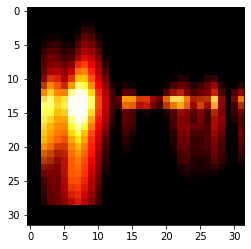

In [ ]:
from data.utils_plot import check_cifar100_dataloader
check_cifar100_dataloader(val_dataloader)

In [ ]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [ ]:
logs = [[] for _ in range(NUM_RUNS)]

for run_i in range(NUM_RUNS):
    net = resnet32()
    
    criterion = nn.CrossEntropyLoss()
    
    for split_i in range(10):
        print(f"## Split {split_i} of run {run_i} ##")

        parameters_to_optimize = net.parameters()
        optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
        scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA)

        manager = Trainer(DEVICE, net, criterion, optimizer, scheduler,
                          train_dataloader[run_i][split_i],
                          val_dataloader[run_i][split_i],
                          test_dataloader[run_i][split_i])

        scores = manager.train(NUM_EPOCHS)  # train the model

        logs[run_i].append({})

        # score[i] = dictionary with key:epoch, value: score
        logs[run_i][split_i]['train_loss'] = scores[0]
        logs[run_i][split_i]['train_accuracy'] = scores[1]
        logs[run_i][split_i]['val_loss'] = scores[2]
        logs[run_i][split_i]['val_accuracy'] = scores[3]

        # Test the model on classes seen until now
        test_accuracy, all_targets, all_preds = manager.test()

        logs[run_i][split_i]['test_accuracy'] = test_accuracy
        logs[run_i][split_i]['conf_mat'] = confusion_matrix(all_targets.to('cpu'), all_preds.to('cpu'))

        # Add 10 nodes to last FC layer
        manager.increment_classes(n=10)

## Split 0 of run 0 ##
Epoch: 1, LR: [2]


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


output: tensor([[ 0.9194, -0.9590,  0.7439, -0.9826, -0.2627, -1.0050,  0.7887,  0.6696,
          2.1407,  0.1130],
        [ 0.3057, -0.9949,  0.1400, -0.2803, -0.0398, -0.2558,  0.2307,  0.8007,
          1.3077,  0.1453],
        [ 0.1413, -1.0062,  0.2902, -0.3347, -0.1481, -0.2450,  0.2323,  0.6183,
          1.4084,  0.2393],
        [ 0.2985, -0.8117,  0.1122, -0.5369, -0.1188, -0.2595,  0.1364,  0.7010,
          1.1449,  0.2312],
        [ 0.3061, -0.9256,  0.3193, -0.3967, -0.1577, -0.2140,  0.3303,  0.6258,
          1.3368,  0.0913],
        [ 0.8168, -0.7340,  0.3187, -0.7376, -0.0913, -0.7567,  0.5063,  0.5420,
          1.8608,  0.1010],
        [ 0.1215, -0.9279,  0.2693, -0.1525,  0.0083, -0.2568,  0.2589,  0.7401,
          1.2438,  0.2118],
        [ 0.2736, -0.9361,  0.2965, -0.3977, -0.0612, -0.0936,  0.3126,  0.5906,
          1.3916,  0.2055],
        [ 0.7158, -0.6735,  0.2820, -0.7241, -0.1995, -0.7049,  0.4589,  0.5945,
          1.4419,  0.0591],
        [ 0

RuntimeError: ignored

In [ ]:
list = [73, 72, 74, 58, 35, 20, 19, 80, 28, 90, 17, 35, 27, 18, 38, 11, 65, 36,
         2, 40, 10, 34, 80, 13, 15, 16, 67, 10, 60, 41, 64, 67, 64, 24, 61, 72,
        35, 67, 33,  5, 86,  3, 38, 92,  4, 43, 24, 80, 20, 25, 71, 65, 26, 70,
         8, 34, 21, 96, 10, 82,  4,  5, 34, 81]

ins = set(list)
len(ins)

46

In [ ]:
tot = set([])
for k in range(1):
  for i in range(5000):
    idx = indexes_train_data[k][i]
    lbl = train_data.__getitem__(idx)[2]
    tot.add(lbl)

tot

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
len(next(iter(test_dataloader[0][9]))[2])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


64

(442, tensor([[[-0.7082, -0.2978,  0.1860,  ..., -0.6496, -0.6789, -1.8957],
          [-0.7229, -0.3857,  0.0687,  ..., -0.6203, -0.6203, -1.8957],
          [-0.7082, -0.4737, -0.0632,  ..., -0.6203, -0.5177, -1.8957],
          ...,
          [-0.4150, -0.1951, -0.0339,  ..., -0.2391, -0.1512, -1.8957],
          [-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.8957],
          [-1.8957, -1.8957, -1.8957,  ..., -1.8957, -1.8957, -1.8957]],
 
         [[-0.7967, -0.0781,  0.6252,  ..., -1.0107, -0.9954, -1.8975],
          [-0.8273, -0.2004,  0.5029,  ..., -1.0107, -0.8884, -1.8975],
          [-0.8578, -0.3227,  0.3653,  ..., -0.9801, -0.6132, -1.8975],
          ...,
          [ 0.1512,  0.2124,  0.1971,  ...,  0.5029,  0.3806, -1.8975],
          [-1.8975, -1.8975, -1.8975,  ..., -1.8975, -1.8975, -1.8975],
          [-1.8975, -1.8975, -1.8975,  ..., -1.8975, -1.8975, -1.8975]],
 
         [[-0.8437, -0.8864, -0.4318,  ..., -0.9432, -0.9432, -1.5965],
          [-0.8011, -0.

## Antonio

In [9]:
  train_data.__shuffle_seed__(RANDOM_SEED[0])
  test_data.__shuffle_seed__(RANDOM_SEED[0])
  

  indexes_train_data = train_data.__incremental_indexes__(True)
  indexes_test_data = test_data.__incremental_indexes__(False)

In [62]:
train_dataloader = [[] for i in range(10)]
val_dataloader = [[] for i in range(10)]
test_dataloader = [[] for i in range(10)]
for i in range(10):
  train_dataset = Subset(train_data, indexes_train_data[i])
  train_set, val_set = torch.utils.data.random_split(train_dataset, [int(0.8*len(indexes_train_data[0])), int(0.2*len(indexes_train_data[0]))])
  tmp_dl = DataLoader(train_set, 
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=4,
                      drop_last=True)
  train_dataloader[i] = copy(tmp_dl)
  tmp_dl = DataLoader(val_set, 
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=4,
                      drop_last=True)
  val_dataloader[i] = copy(tmp_dl)


  test_dataset = Subset(test_data, indexes_test_data[i])
  tmp_dl = DataLoader(test_dataset,
                      batch_size=BATCH_SIZE,
                      shuffle=True,
                      num_workers=4,
                      drop_last=True)
  test_dataloader[i] = copy(tmp_dl)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [44]:
import torch
import torch.nn as nn
from torch.backends import cudnn
from copy import deepcopy

In [45]:
def to_onehot(net, targets, device): 
  '''
  Args:
  targets : dataloader.dataset.targets of the new task images
  '''
  num_classes = net.fc.out_features
  one_hot_targets = torch.eye(num_classes)[targets]

  return one_hot_targets.to(device)

In [46]:
def train(net, criterion, optimizer, train_dl, device):
  net.train()

  running_loss = 0

  for batch in train_dl:
    labels = batch[2]
    images = batch[1]
    optimizer.zero_grad()

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    one_hot_labels = to_onehot(net, labels, device) 

    output = net(images)
    loss = criterion(output, one_hot_labels)
    loss.backward()
    optimizer.step()
    
    running_loss += loss.item()
  else:
    epoch_loss = running_loss/len(train_dl)
  return epoch_loss
    

In [47]:
#### VALIDATION

def validate(net, criterion, optimizer, validation_dl, device):
  net.train(False)
  running_loss=0
  running_corrects = 0
  total = 0
  for batch in validation_dl:
    labels = batch[2]
    images = batch[1]
    total += labels.size(0)
    optimizer.zero_grad()

    images = images.to(DEVICE)
    labels = labels.to(DEVICE)

    one_hot_labels = to_onehot(net, labels, device) 

    output = net(images)
    loss = criterion(output, one_hot_labels)
    
    running_loss += loss.item()
    _, preds = torch.max(output.data, 1)
    running_corrects += torch.sum(preds == labels.data).data.item()
  else:
    val_loss = running_loss/len(validation_dl)
    

  val_accuracy = running_corrects / float(total)
  

  return val_loss, val_accuracy

In [63]:
def test(best_net, test_dl, device):
  """Test the model.
  Returns:
      accuracy (float): accuracy of the model on the test set
  """

  best_net.train(False)  # Set Network to evaluation mode

  running_corrects = 0
  total = 0

  all_preds = torch.tensor([]) # to store all predictions
  all_preds = all_preds.type(torch.LongTensor)
  all_targets = torch.tensor([])
  all_targets = all_targets.type(torch.LongTensor)

  for _, images, labels in test_dl:
      images = images.to(device)
      labels = labels.to(device)
      total += labels.size(0)

      # Forward Pass
      outputs = best_net(images)

      # Get predictions
      _, preds = torch.max(outputs.data, 1)

      # Update Corrects
      running_corrects += torch.sum(preds == labels.data).data.item()

      # Append batch predictions and labels
      all_targets = torch.cat(
          (all_targets.to(device), labels.to(device)), dim=0
      )
      all_preds = torch.cat(
          (all_preds.to(device), preds.to(device)), dim=0
      )

  # Calculate accuracy
  accuracy = running_corrects / float(total)  


  return accuracy, all_targets, all_preds

In [67]:
def increment_classes(net, n=10):
  """Add n classes in the final fully connected layer."""

  in_features = net.fc.in_features  # size of each input sample
  out_features = net.fc.out_features  # size of each output sample
  weight = net.fc.weight.data

  net.fc = nn.Linear(in_features, out_features+n)
  net.fc.weight.data[:out_features] = weight

In [69]:
net = resnet32()
criterion = nn.BCEWithLogitsLoss()



net.to(DEVICE)
cudnn.benchmark
num_epochs = 80

epoch_losses = [[] for i in range(10)]
for i in range(10):
  net.to(DEVICE)
  parameters_to_optimize = net.parameters()
  optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
  scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA)

  best_acc = 0
  best_net = deepcopy(net)

  for epoch in range(num_epochs):
    e_loss = train(net, criterion, optimizer, train_dataloader[i], DEVICE)
    epoch_losses[i].append(e_loss)
    print(f"Epoch[{epoch}] loss: {e_loss} LR: {scheduler.get_last_lr()}")
    validate_loss, validate_acc = validate(net, criterion, optimizer, val_dataloader[i], DEVICE)
    print(f"Validation on group[{i}] of 10 classes")
    print(f"val loss: {validate_loss}")
    print(f"val acc: {validate_acc}")
    scheduler.step()
    if validate_acc > best_acc:
      best_acc = validate_acc
      best_net = deepcopy(net)
      best_epoch = epoch
      print("Best model updated")
    print("")

  print(f"Group[{i}]Finished!")
  print(f"Best model at epoch {best_epoch}, best accuracy: {best_acc:.2f}")
  print("")
  acc_all, all_targets, all_preds = test(best_net, test_dataloader[i], DEVICE)
  print(f"Testing classes seen so far, accuracy: {acc_all}")
  print("")
  print("=============================================")
  print("")

  if i < 9:
    increment_classes(net)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch[0] loss: 0.43079329306079495 LR: [2]
Validation on group[0] of 10 classes
val loss: 1.4764954703194755
val acc: 0.11941964285714286
Best model updated

Epoch[1] loss: 0.3252225075998614 LR: [2]
Validation on group[0] of 10 classes
val loss: 0.32302625690187725
val acc: 0.13058035714285715
Best model updated

Epoch[2] loss: 0.3226424321051567 LR: [2]
Validation on group[0] of 10 classes
val loss: 0.3273803847176688
val acc: 0.1328125
Best model updated

Epoch[3] loss: 0.32311999317138423 LR: [2]
Validation on group[0] of 10 classes
val loss: 0.3209583716733115
val acc: 0.140625
Best model updated

Epoch[4] loss: 0.3208273658829351 LR: [2]
Validation on group[0] of 10 classes
val loss: 0.32389557361602783
val acc: 0.15513392857142858
Best model updated

Epoch[5] loss: 0.31891891744828993 LR: [2]
Validation on group[0] of 10 classes
val loss: 0.32285150459834505
val acc: 0.15401785714285715

Epoch[6] loss: 0.31827220512974647 LR: [2]
Validation on group[0] of 10 classes
val loss: 0.

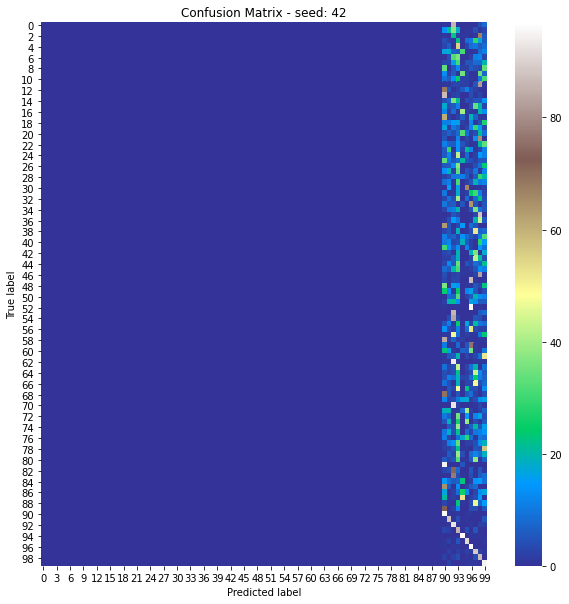

In [71]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
def plotConfusionMatrix(confusionMatrixData, seed):
	fig,ax=plt.subplots(figsize=(10,10))
	sns.heatmap(confusionMatrixData,cmap='terrain',ax=ax)
	plt.ylabel('True label')
	plt.xlabel('Predicted label')
	plt.title("Confusion Matrix - seed: {}".format(seed))

	#filename = "cm_{}_{}.jpg".format(method, seed) # ex. cm_lwf_30
	#plt.savefig(filename, format='png', dpi=300)
	plt.show()
t = all_targets.cpu().data.numpy()
p = all_preds.cpu().data.numpy()
confusionMatrixData = confusion_matrix(t, p)
plotConfusionMatrix(confusionMatrixData, RANDOM_SEED[0])
